# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Read Data

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

# Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

# Adding Dummy varibales

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [9]:
cat_cols = df.select_dtypes(include=['object']).columns
dummies = pd.get_dummies(df[cat_cols])
df_dummies = pd.concat([df, dummies], axis=1)
df_dummies = df_dummies.drop(["sales_channel","trip_type","route","booking_origin"], axis=1)

In [10]:
df_dummies

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,6,1,0,0,5.52,0,...,False,False,False,False,False,False,False,False,False,False
1,1,112,20,3,6,0,0,0,5.52,0,...,False,False,False,False,False,False,False,False,False,False
2,2,243,22,17,3,1,1,0,5.52,0,...,False,False,False,False,False,False,False,False,False,False
3,1,96,31,4,6,0,0,1,5.52,0,...,False,False,False,False,False,False,False,False,False,False
4,2,68,22,15,3,1,0,1,5.52,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,6,1,0,1,5.62,0,...,False,False,False,False,False,False,False,False,False,False
49996,1,111,6,4,7,0,0,0,5.62,0,...,False,False,False,False,False,False,False,False,False,False
49997,1,24,6,22,6,0,0,1,5.62,0,...,False,False,False,False,False,False,False,False,False,False
49998,1,15,6,11,1,1,0,1,5.62,0,...,False,False,False,False,False,False,False,False,False,False


# Visualize Data

In [11]:
num_cols = df.select_dtypes(exclude=['object']).columns
for_fig = df[num_cols]

In [12]:
for_fig = for_fig.drop(["wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals","booking_complete"], axis=1)

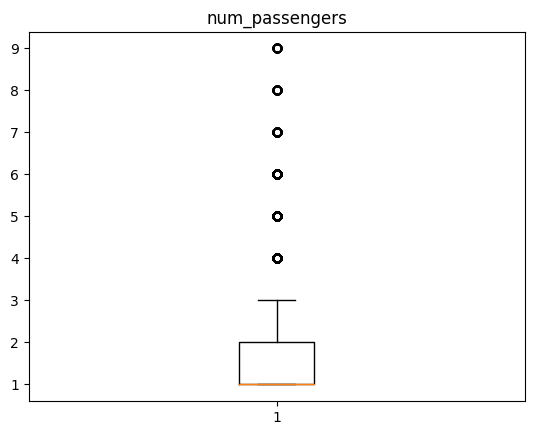

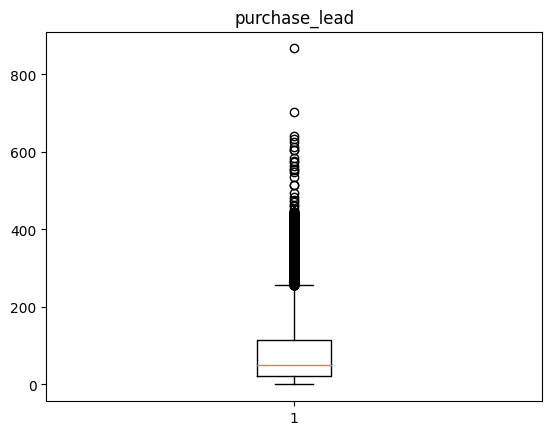

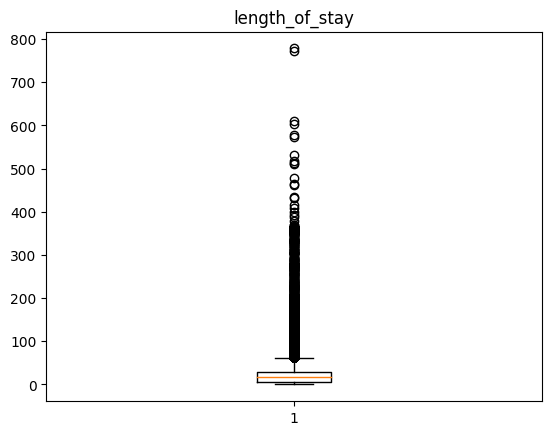

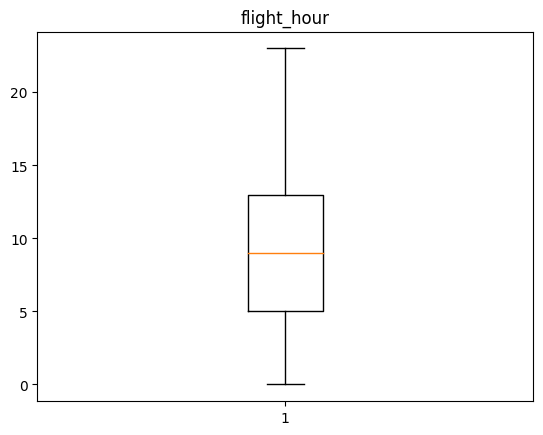

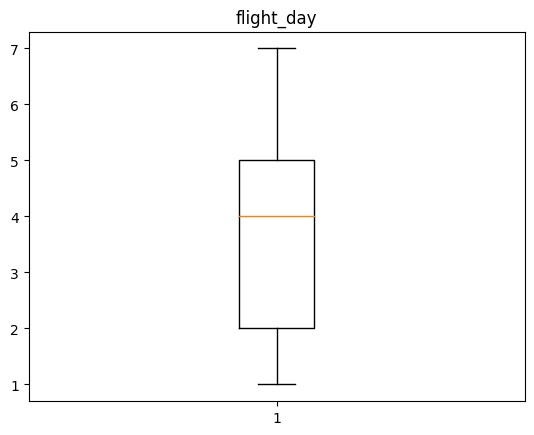

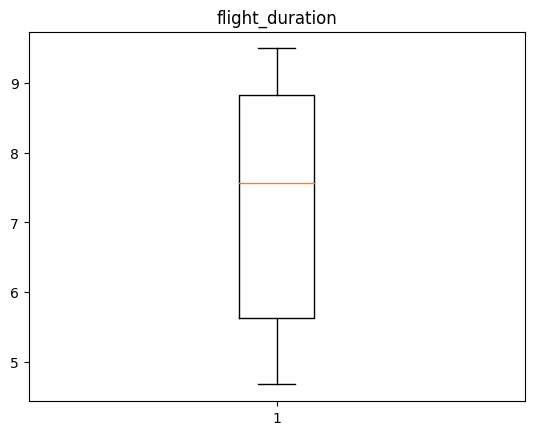

In [13]:
for i in for_fig:
    plt.figure()
    plt.title(i)
    plt.boxplot(df[i])

In [14]:
for_fig

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration
0,2,262,19,7,6,5.52
1,1,112,20,3,6,5.52
2,2,243,22,17,3,5.52
3,1,96,31,4,6,5.52
4,2,68,22,15,3,5.52
...,...,...,...,...,...,...
49995,2,27,6,9,6,5.62
49996,1,111,6,4,7,5.62
49997,1,24,6,22,6,5.62
49998,1,15,6,11,1,5.62


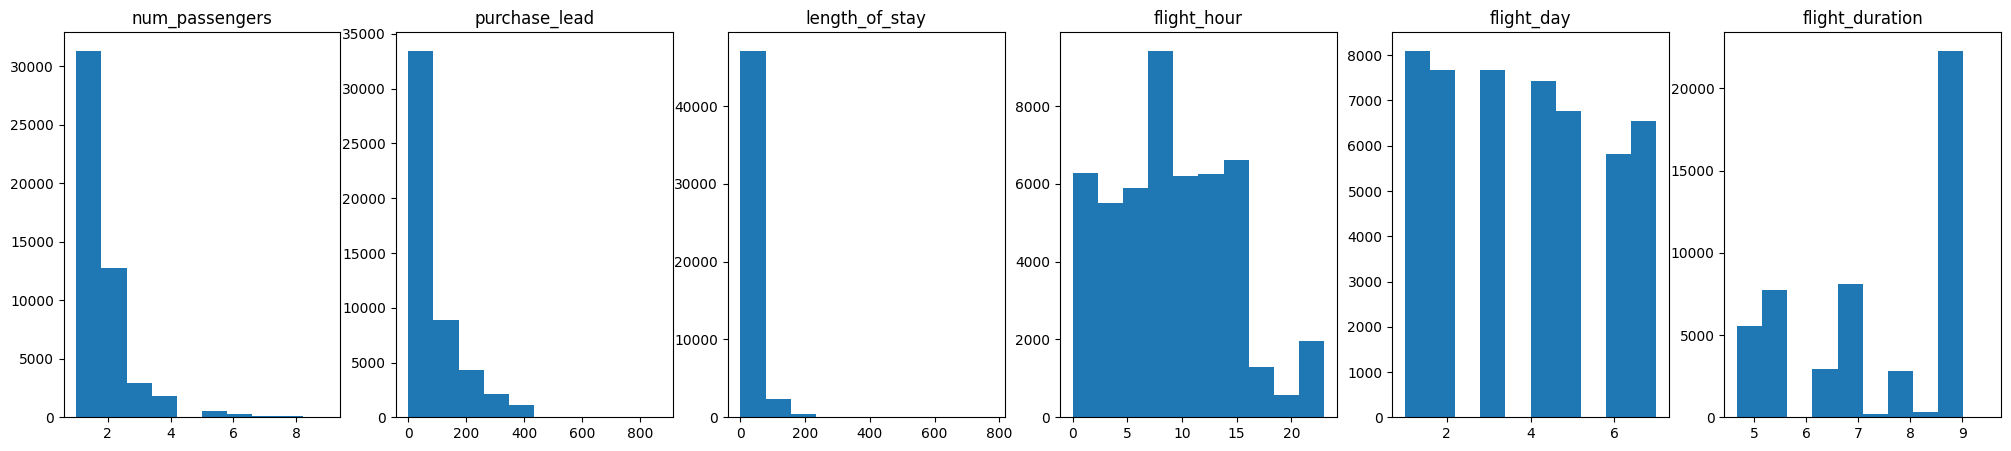

In [15]:
fig, axs = plt.subplots(1, len(for_fig.columns), figsize=(25, 5))
for i, col in enumerate(for_fig.columns):
    axs[i].hist(for_fig[col])
    axs[i].set_title(col)
plt.show()

# Normizling Data

In [16]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize each column in the dataframe
for col in for_fig.columns:
    normalized_col = scaler.fit_transform(for_fig[col].values.reshape(-1,1))
    for_fig[col] = normalized_col

In [17]:
for_fig

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration
0,0.125,0.302191,0.024422,0.304348,0.833333,0.175983
1,0.000,0.129181,0.025707,0.130435,0.833333,0.175983
2,0.125,0.280277,0.028278,0.739130,0.333333,0.175983
3,0.000,0.110727,0.039846,0.173913,0.833333,0.175983
4,0.125,0.078431,0.028278,0.652174,0.333333,0.175983
...,...,...,...,...,...,...
49995,0.125,0.031142,0.007712,0.391304,0.833333,0.196687
49996,0.000,0.128028,0.007712,0.173913,1.000000,0.196687
49997,0.000,0.027682,0.007712,0.956522,0.833333,0.196687
49998,0.000,0.017301,0.007712,0.478261,0.000000,0.196687


In [18]:
# Replace columns of df_dummies with columns of for_fig
df_dummies.loc[:, for_fig.columns] = for_fig
df_dummies

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0.125,0.302191,0.024422,0.304348,0.833333,1,0,0,0.175983,0,...,False,False,False,False,False,False,False,False,False,False
1,0.000,0.129181,0.025707,0.130435,0.833333,0,0,0,0.175983,0,...,False,False,False,False,False,False,False,False,False,False
2,0.125,0.280277,0.028278,0.739130,0.333333,1,1,0,0.175983,0,...,False,False,False,False,False,False,False,False,False,False
3,0.000,0.110727,0.039846,0.173913,0.833333,0,0,1,0.175983,0,...,False,False,False,False,False,False,False,False,False,False
4,0.125,0.078431,0.028278,0.652174,0.333333,1,0,1,0.175983,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.125,0.031142,0.007712,0.391304,0.833333,1,0,1,0.196687,0,...,False,False,False,False,False,False,False,False,False,False
49996,0.000,0.128028,0.007712,0.173913,1.000000,0,0,0,0.196687,0,...,False,False,False,False,False,False,False,False,False,False
49997,0.000,0.027682,0.007712,0.956522,0.833333,0,0,1,0.196687,0,...,False,False,False,False,False,False,False,False,False,False
49998,0.000,0.017301,0.007712,0.478261,0.000000,1,0,1,0.196687,0,...,False,False,False,False,False,False,False,False,False,False


# Split Data into Train and Test

In [19]:
features=df_dummies.drop("booking_complete",axis=1)
target=df_dummies["booking_complete"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features,target,train_size=0.8)

# Training Classification models

# Random Forest Model

In [21]:
# train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [22]:
# make predictions on the testing set
y_pred = rf.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8542


# Logistic Regression Model

In [23]:
# Define the logistic regression model
lr = LogisticRegression()
lr.fit(X_train,y_train)

C:\python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
# make predictions on the testing set
y_pred_lr = lr.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

Accuracy: 0.8549


# SVM Model

In [25]:
sv = SVC()

In [26]:
sv.fit(X_train,y_train)

SVC()

In [27]:
# make predictions on the testing set
y_pred_sv = sv.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred_sv)
print("Accuracy:", accuracy)

Accuracy: 0.8538


# PCA three main features

In [34]:
# Create a PCA object
pca = PCA()

# Fit the PCA model to your data
pca.fit(X_train)

# Get the names of the original features
feature_names = X_train.columns

# Get the explained variance of each principal component
explained_variance = pca.explained_variance_ratio_

# Get the indices of the three most important components
top_component_indices = explained_variance.argsort()[::-1][:3]

# Get the names of the three most important features
top_feature_names = feature_names[top_component_indices]

print("The three most important features are:")
for feature in top_feature_names:
    print(feature)

The three most important features are:
num_passengers
purchase_lead
length_of_stay


# Traning models on two main features

In [35]:
# Instantiate a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the data and transform it
X_pca = pca.fit_transform(df_dummies)

In [36]:
Pca_feat = X_train[["num_passengers","purchase_lead","length_of_stay"]]

In [37]:
Pca_test = X_test[["num_passengers","purchase_lead","length_of_stay"]]

In [38]:
Pca_feat

,num_passengers,purchase_lead,length_of_stay
20069,0.000,0.092272,0.102828
25346,0.125,0.079585,0.044987
20118,0.500,0.246828,0.033419
45571,0.125,0.475202,0.007712
25492,0.000,0.058824,0.047558
...,...,...,...
24986,0.000,0.102653,0.032134
38319,0.125,0.055363,0.006427
24729,0.375,0.154556,0.043702
45793,0.125,0.099193,0.007712


In [39]:
y_train

20069    0
25346    0
20118    0
45571    0
25492    0
        ..
24986    1
38319    0
24729    0
45793    0
26727    0
Name: booking_complete, Length: 40000, dtype: int64

In [40]:
# train the Random Forest model
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(Pca_feat, y_train)


RandomForestClassifier(random_state=42)

In [41]:
# train the Logistic model
lg_pca = LogisticRegression()
lg_pca.fit(Pca_feat, y_train)


LogisticRegression()

In [42]:
# train the SVM
svm_pca = SVC()
svm_pca.fit(Pca_feat, y_train)

SVC()

# Scrore of the models

In [43]:
y_pred_pca = rf_pca.predict(Pca_feat)
accuracy = accuracy_score(y_train, y_pred_pca)
print(f"Random forest Accuracy score: {accuracy}")

y_pred_lg = lg_pca.predict(Pca_feat)
accuracy = accuracy_score(y_train, y_pred_lg)
print(f"Logistic regression Accuracy score: {accuracy}")

y_pred_svm = svm_pca.predict(Pca_feat)
accuracy = accuracy_score(y_train, y_pred_svm)
print(f"SVm Accuracy score: {accuracy}")

Random forest Accuracy score: 0.890675
Logistic regression Accuracy score: 0.84965
SVm Accuracy score: 0.849675


In [44]:
# Perform 5-fold cross-validation on the model
scores = cross_val_score(rf_pca, Pca_feat, y_train, cv=10)

# Print the average score and standard deviation
print(f"Random forest Average score: {scores.mean():.2f}")
print(f"Random forest Standard deviation: {scores.std():.2f}")

Random forest Average score: 0.82
Random forest Standard deviation: 0.00


In [45]:
scores

array([0.8145 , 0.821  , 0.81775, 0.818  , 0.821  , 0.818  , 0.8185 ,
       0.822  , 0.815  , 0.82175])

In [46]:
y_pca_pred = rf_pca.predict(Pca_test)

In [47]:
# Perform 5-fold cross-validation on the model
scores_lg = cross_val_score(lg_pca, Pca_feat, y_train, cv=10)

# Print the average score and standard deviation
print(f"Logistic regression Average score: {scores_lg.mean():.2f}")
print(f"Logistic regression Standard deviation: {scores_lg.std():.2f}")

Logistic regression Average score: 0.85
Logistic regression Standard deviation: 0.00


In [48]:
scores_lg

array([0.84975, 0.84975, 0.84975, 0.84975, 0.84975, 0.84975, 0.8495 ,
       0.8495 , 0.8495 , 0.8495 ])

In [49]:
# Perform 5-fold cross-validation on the model
scores_svm = cross_val_score(svm_pca, Pca_feat, y_train, cv=10)

# Print the average score and standard deviation
print(f"Average score: {scores_svm.mean():.2f}")
print(f"Standard deviation: {scores_svm.std():.2f}")

Average score: 0.85
Standard deviation: 0.00


In [50]:
scores_svm

array([0.84975, 0.84975, 0.84975, 0.84975, 0.84975, 0.84975, 0.8495 ,
       0.8495 , 0.8495 , 0.8495 ])

# Evaluation of all trained models

In [51]:
# Assuming you have ground truth labels y_true and predicted labels y_pred
accuracy = accuracy_score(y_test, y_pca_pred)
precision = precision_score(y_test, y_pca_pred)
recall = recall_score(y_test, y_pca_pred)
f1 = f1_score(y_test, y_pca_pred)
auc_roc = roc_auc_score(y_test, y_pca_pred)
conf_matrix = confusion_matrix(y_test, y_pca_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("AUC-ROC:", auc_roc)
print("Confusion matrix:\n", conf_matrix)

Accuracy: 0.8241
Precision: 0.19461697722567287
Recall: 0.06420765027322405
F1 score: 0.09655880842321521
AUC-ROC: 0.5093179769641659
Confusion matrix:
 [[8147  389]
 [1370   94]]
